Connected to base (Python 3.13.9)

In [ ]:
"""
Plot braiding index evolution per hydrodynamic cycle.

This script:
1. Loads braiding index data from cache OR computes it if not available
2. Splits the time series into individual hydrodynamic annual cycles
3. Plots each cycle as a separate line (light-to-dark coloring by cycle number)
4. Overlays the discharge signal on a secondary y-axis

Self-contained: computes and caches data if cache doesn't exist.
"""

#%% IMPORTS
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import cKDTree
from tqdm import tqdm
import sys

sys.path.append(r"c:\Users\marloesbonenka\Nextcloud\Python\01_Delft3D-FM\02_Postprocessing")

from FUNCTIONS.F_general import *
from FUNCTIONS.F_braiding_index import *
from FUNCTIONS.F_cache import *
from FUNCTIONS.F_loaddata import read_discharge_from_bc_files, extract_discharge_at_x, split_by_hydrodynamic_cycle

In [ ]:
# ANALYSIS_MODE: "variability" for river discharge variability scenarios
#                "morfac" for MORFAC sensitivity analysis
ANALYSIS_MODE = "variability"

if ANALYSIS_MODE == "variability":
    base_directory = Path(r"U:\PhDNaturalRhythmEstuaries\Models\1_RiverDischargeVariability_domain45x15")
    config = 'Model_Output'
    default_morfac = 100  # All variability scenarios use MORFAC=100
    VARIABILITY_MAP = {
        '1': '01_baserun500',
        '2': '02_run500_seasonal',
        '3': '03_run500_flashy',
        '4': '04_run500_singlepeak',
    }
    SCENARIOS_TO_PROCESS = ['2']  # e.g., ['1'] for baserun only

elif ANALYSIS_MODE == "morfac":
    base_directory = Path(r"U:\PhDNaturalRhythmEstuaries\Models\1_RiverDischargeVariability_domain45x15")
    config = r'TestingBoundaries_and_SensitivityAnalyses\Test_MORFAC\02_seasonal\Tmorph_50years'
    default_morfac = None

timed_out_dir = base_directory / config / "timed-out"

# --- SETTINGS ---
n_slices = 5  
safety_buffer = 0.20 

# Cross-section x-coordinates in meters
selected_x_coords = [20000, 30000, 40000]

# Y-range of the estuary (min, max) and sampling resolution
y_range = (5000, 10000)
n_y_samples = 150

# --- HYDRODYNAMIC CYCLE SETTINGS ---
# Duration of ONE hydrodynamic cycle in days (1 year = 365.25 days)
HYDRO_CYCLE_DAYS = 365.25

# X-coordinate for discharge extraction (km 40 = 40000 m)
DISCHARGE_X_COORD = 40000

# --- CACHE SETTINGS ---
compute = False  # Set True to force recompute, False to use cache

cache_settings = {
    'selected_x_coords': selected_x_coords,
    'y_range': y_range,
    'n_y_samples': n_y_samples,
    'safety_buffer': safety_buffer,
    'n_slices': n_slices,
}


PROCESSING: 2_Q500_rst_seasonal.9093860
Attempting to read discharge from BC input files...
  Found 4 BC files: ['01_Qr500_inflow_sinuous.bc', '02_Qr500_inflow_sinuous.bc', '03_Qr500_inflow_sinuous.bc', '04_Qr500_inflow_sinuous.bc']
  Read 18994 timesteps from BC files (ref: 2001-01-01 00:00:00)
No cache found, computing profiles...
Stitching 2 run parts...


   Opening run parts:   0%|          | 0/2 [00:00<?, ?it/s]

   -> Opening Map: 02_run500_seasonal
Loading partitioned dataset: U:\PhDNaturalRhythmEstuaries\Models\1_RiverDischargeVariability_domain45x15\Model_Output\timed-out\02_run500_seasonal\output\*_map.nc
>> xu.open_dataset() with 48 partition(s): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 : 620.82 sec
>> xu.merge_partitions() with 48 partition(s): 1.36 sec
>> dfmt.open_partitioned_dataset() total: 622.25 sec


   Opening run parts:  50%|█████     | 1/2 [10:26<10:26, 626.29s/it]

   -> Opening Map: 2_Q500_rst_seasonal.9093860
Loading partitioned dataset: U:\PhDNaturalRhythmEstuaries\Models\1_RiverDischargeVariability_domain45x15\Model_Output\2_Q500_rst_seasonal.9093860\output\*_map.nc
>> xu.open_dataset() with 48 partition(s): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 : 272.72 sec
>> xu.merge_partitions() with 48 partition(s): 1.37 sec
>> dfmt.open_partitioned_dataset() total: 274.29 sec


   Opening run parts: 100%|██████████| 2/2 [15:01<00:00, 450.51s/it]


   Saved profiles to cache: U:\PhDNaturalRhythmEstuaries\Models\1_RiverDischargeVariability_domain45x15\Model_Output\2_Q500_rst_seasonal.9093860\cache_profiles_2_Q500_rst_seasonal.9093860.pkl
  Found 53 hydrodynamic cycles for discharge (source: BC files).
  km20: 30 hydrodynamic cycles detected.
  km30: 30 hydrodynamic cycles detected.
  km40: 30 hydrodynamic cycles detected.


<ipython-input-3-0f3ec6c00725>:380: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])  # Leave space for colorbar on right


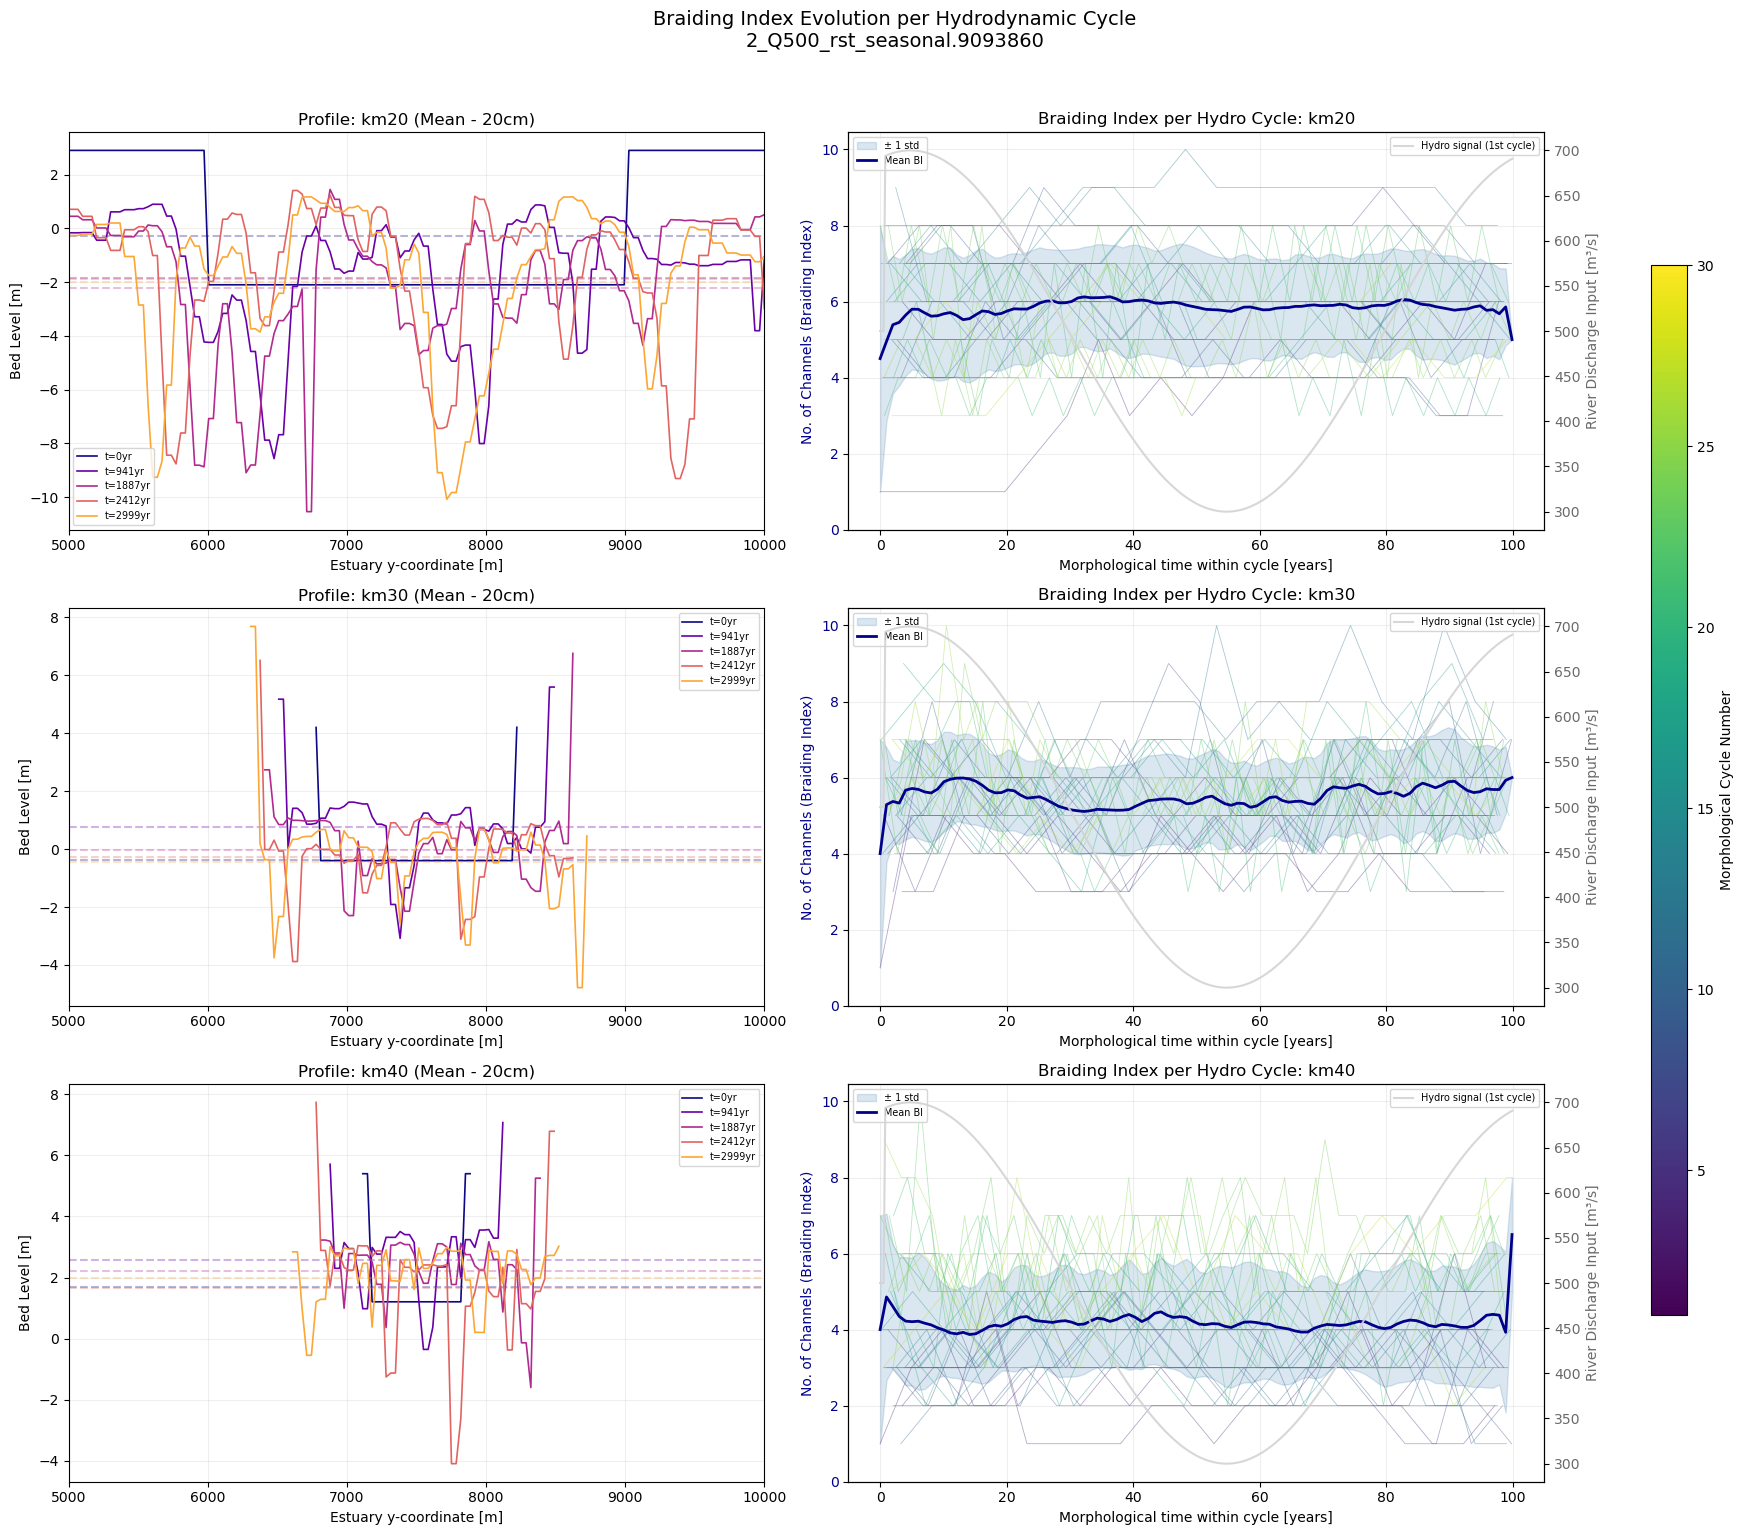

Saved: braiding_index_cycles_2_Q500_rst_seasonal.9093860.png

ALL FOLDERS COMPLETED.


In [ ]:
if __name__ == "__main__":
    # For variability: restart folders start with digit
    if ANALYSIS_MODE == "variability":
        model_folders = [f.name for f in (base_directory / config).iterdir() 
                         if f.is_dir() and f.name[0].isdigit() and '_rst' in f.name.lower()]
        if SCENARIOS_TO_PROCESS:
            model_folders = [f for f in model_folders if f.split('_')[0] in SCENARIOS_TO_PROCESS]
        model_folders.sort(key=lambda x: int(x.split('_')[0]))
    elif ANALYSIS_MODE == "morfac":
        model_folders = [f.name for f in (base_directory / config).iterdir() 
                         if f.is_dir() and f.name.startswith('MF')]
        model_folders.sort(key=get_mf_number)

    dataset_cache = DatasetCache()
    
    for folder in model_folders:
        model_location = base_directory / config / folder
        
        print(f"\n" + "="*60)
        print(f"PROCESSING: {folder}")
        
        # --- 1. LOAD OR COMPUTE BRAIDING INDEX ---
        cache_path = get_profile_cache_path(model_location, folder)
        folder_results, missing_x_coords = load_profile_cache(cache_path, selected_x_coords)
        
        # Compute bi_series from profiles if cached but bi_series missing
        for cs_name, data in folder_results.items():
            if 'time_series' not in data and 'times' in data:
                data['time_series'] = data['times']
            if 'bi_series' not in data and 'profiles' in data:
                print(f"   Computing braiding index for {cs_name} from cached profiles...")
                data['bi_series'] = []
                for profile in data['profiles']:
                    plot_profile = profile.copy()
                    plot_profile[plot_profile > 8.0] = np.nan
                    bi = compute_braiding_index_with_threshold(plot_profile, safety_buffer=safety_buffer)
                    data['bi_series'].append(bi)

        # --- 2. GET DISCHARGE (Priority: BC files > Cache > Map extraction) ---
        discharge_cache_key = "discharge_bc"
        all_discharge_times = []
        all_discharge_values = []
        discharge_source = None

        # Option A: Try reading from BC input files (fastest)
        print("Attempting to read discharge from BC input files...")
        bc_times, bc_values = read_discharge_from_bc_files(model_location)

        if bc_times is not None:
            all_discharge_times = bc_times
            all_discharge_values = bc_values
            discharge_source = "BC files"
        else:
            # Option B: Check cache (stored inside first cross-section entry)
            for cs_name, data in folder_results.items():
                if discharge_cache_key in data:
                    all_discharge_times = data[discharge_cache_key]['times']
                    all_discharge_values = data[discharge_cache_key]['values']
                    discharge_source = "cache"
                    print(f"Loaded discharge from cache ({len(all_discharge_times)} timesteps).")
                    break

        need_discharge_from_map = not bool(all_discharge_times)
        
        # --- BUILD RUN PATHS (needed for both computing and discharge extraction) ---
        all_run_paths = []
        
        if ANALYSIS_MODE == "variability":
            scenario_num = folder.split('_')[0]
            if scenario_num in VARIABILITY_MAP and timed_out_dir.exists():
                timed_out_folder = VARIABILITY_MAP[scenario_num]
                timed_out_path = timed_out_dir / timed_out_folder
                if timed_out_path.exists():
                    all_run_paths.append(timed_out_path)
        elif ANALYSIS_MODE == "morfac":
            if 'restart' in folder:
                mf_prefix = folder.split('_')[0]
                if timed_out_dir.exists():
                    match = [f.name for f in timed_out_dir.iterdir() if f.name.startswith(mf_prefix)]
                    if match:
                        all_run_paths.append(timed_out_dir / match[0])
        
        all_run_paths.append(model_location)

        # --- OPEN MAP OUTPUT ONLY IF NEEDED (profiles and/or discharge fallback) ---
        need_profiles_from_map = (not folder_results) or bool(missing_x_coords)
        need_map_open = need_profiles_from_map or need_discharge_from_map

        loaded_datasets = []
        loaded_trees = []

        if need_map_open:
            if need_profiles_from_map:
                if not folder_results:
                    print("No cache found, computing profiles...")
                    missing_x_coords = selected_x_coords
                else:
                    print(f"Partial cache found. Computing missing cross-sections: {[f'km{int(x/1000)}' for x in missing_x_coords]}")

            print(f"Stitching {len(all_run_paths)} run parts...")

            variables_to_open = ['mesh2d_mor_bl', 'mesh2d_face_x', 'mesh2d_face_y']
            if need_discharge_from_map:
                variables_to_open += ['mesh2d_q1', 'mesh2d_edge_x', 'mesh2d_edge_y']
            variables_to_open = list(dict.fromkeys(variables_to_open))

            try:
                for p_path in tqdm(all_run_paths, desc="   Opening run parts", leave=True):
                    print(f"   -> Opening Map: {p_path.name}")
                    ds = dataset_cache.get_partitioned(
                        str(p_path / 'output' / '*_map.nc'),
                        variables=variables_to_open,
                        chunks={'time': 200},
                    )
                    loaded_datasets.append(ds)

                    if need_profiles_from_map:
                        face_x = ds['mesh2d_face_x'].values
                        face_y = ds['mesh2d_face_y'].values
                        tree = cKDTree(np.vstack([face_x, face_y]).T)
                        loaded_trees.append(tree)

                # --- Compute missing profiles/BI ---
                if need_profiles_from_map:
                    y_samples = np.linspace(y_range[0], y_range[1], n_y_samples)
                    dist = y_samples - y_samples[0]

                    cs_defs = []
                    new_results = {}
                    for x_coord in missing_x_coords:
                        cs_name = f"km{int(x_coord / 1000)}"
                        cs_x = np.full(n_y_samples, x_coord)
                        cs_y = y_samples
                        cs_defs.append((cs_name, cs_x, cs_y))
                        new_results[cs_name] = {
                            'bi_series': [],
                            'times': [],
                            'time_series': [],
                            'profiles': [],
                            'dist': dist,
                        }

                    for ds_map, tree in zip(loaded_datasets, loaded_trees):
                        cs_indices = []
                        cs_slices = []
                        offset = 0
                        for cs_name, cs_x, cs_y in cs_defs:
                            nearest_indices = get_nearest_face_indices(tree, cs_x, cs_y)
                            cs_indices.append(nearest_indices)
                            cs_slices.append((cs_name, offset, offset + len(nearest_indices)))
                            offset += len(nearest_indices)

                        all_indices = np.concatenate(cs_indices)
                        xr_ds = getattr(ds_map, 'obj', ds_map)
                        bl_all = xr_ds['mesh2d_mor_bl'].isel(mesh2d_nFaces=all_indices).values
                        time_vals = pd.to_datetime(xr_ds.time.values)

                        for t in tqdm(range(bl_all.shape[0]), desc="      Timesteps", leave=False):
                            row = bl_all[t, :]
                            time_val = time_vals[t]
                            for cs_name, start, end in cs_slices:
                                plot_profile = row[start:end].copy()
                                plot_profile[plot_profile > 8.0] = np.nan
                                bi = compute_braiding_index_with_threshold(plot_profile, safety_buffer=safety_buffer)

                                new_results[cs_name]['bi_series'].append(bi)
                                new_results[cs_name]['times'].append(time_val)
                                new_results[cs_name]['time_series'].append(time_val)
                                new_results[cs_name]['profiles'].append(plot_profile)

                    folder_results.update(new_results)
                    save_profile_cache(cache_path, new_results, cache_settings)
                    print(f"   Saved profiles to cache: {cache_path}")
                else:
                    print(f"Loaded {len(folder_results)} cross-sections from cache.")

                # --- Discharge fallback from MAP (only if BC/cache not available) ---
                if need_discharge_from_map:
                    print("Extracting discharge from map files (fallback)...")
                    for ds in loaded_datasets:
                        q_times, q_values = extract_discharge_at_x(ds, DISCHARGE_X_COORD, y_range)
                        if q_times is not None:
                            all_discharge_times.extend(q_times)
                            all_discharge_values.extend(q_values)

                    if all_discharge_times:
                        discharge_source = "map files"

                        # Save discharge to cache for next time
                        if folder_results:
                            first_cs = list(folder_results.keys())[0]
                            discharge_data = {
                                discharge_cache_key: {
                                    'times': all_discharge_times,
                                    'values': all_discharge_values,
                                }
                            }
                            save_profile_cache(cache_path, {first_cs: discharge_data}, cache_settings)
                            print(f"  Saved discharge to cache: {discharge_cache_key}")

            except Exception as e:
                print(f"Error processing {folder}: {e}")
                import traceback
                traceback.print_exc()
                continue
        else:
            print(f"Loaded {len(folder_results)} cross-sections from cache.")
        
        if not all_discharge_times:
            print("  Warning: Could not extract discharge. Skipping discharge plot.")
            discharge_cycles = None
        else:
            discharge_cycles = split_by_hydrodynamic_cycle(
                all_discharge_times, all_discharge_values, HYDRO_CYCLE_DAYS
            )
            print(f"  Found {len(discharge_cycles)} hydrodynamic cycles for discharge (source: {discharge_source}).")
        
        # Set discharge label based on source
        if discharge_source == "BC files":
            discharge_label = "River Discharge Input [m³/s]"
        else:
            discharge_label = f"Discharge at km{int(DISCHARGE_X_COORD/1000)} [m³/s]"
        
        # --- 3. PLOTTING ---
        morfac = default_morfac if default_morfac else float(get_mf_number(folder))
        
        n_cs = len(selected_x_coords)
        fig, axes = plt.subplots(n_cs, 2, figsize=(18, 5 * n_cs))
        if n_cs == 1:
            axes = axes.reshape(1, -1)
        
        for i, x_coord in enumerate(selected_x_coords):
            cs_name = f"km{int(x_coord / 1000)}"
            if cs_name not in folder_results:
                print(f"  Skipping {cs_name}: not in cache.")
                continue
            
            data = folder_results[cs_name]
            ax_spatial, ax_bi = axes[i, 0], axes[i, 1]
            
            # Build DataFrame
            df_results = pd.DataFrame({
                'time': data['time_series'], 
                'bi': data['bi_series'], 
                'p_idx': range(len(data['profiles']))
            })
            df_results = df_results.drop_duplicates('time').sort_values('time')
            
            # --- LEFT PANEL: Profiles at selected times (same as before) ---
            times = pd.to_datetime(df_results['time'])
            t0 = times.iloc[0]
            hydro_days = (times - t0).dt.total_seconds() / 86400
            morph_years = (hydro_days * morfac) / 365.25
            df_results['morph_years'] = morph_years
            
            slice_indices = np.linspace(0, len(df_results) - 1, n_slices, dtype=int)
            profile_colors = plt.cm.plasma(np.linspace(0, 0.8, n_slices))
            
            dist = data['dist']
            # Convert relative distance to actual estuary y-coordinates
            y_coords_plot = dist + y_range[0]
            all_profiles_raw = data['profiles']
            
            for c_idx, row_idx in enumerate(slice_indices):
                data_row = df_results.iloc[row_idx]
                prof = all_profiles_raw[int(data_row['p_idx'])]
                lbl = f"t={int(data_row['morph_years'])}yr"
                
                ax_spatial.plot(y_coords_plot, prof, color=profile_colors[c_idx], label=lbl, linewidth=1.2)
                ax_spatial.axhline(np.nanmean(prof) - safety_buffer, color=profile_colors[c_idx], 
                                   linestyle='--', alpha=0.3)
            
            ax_spatial.set_title(f"Profile: {cs_name} (Mean - {int(safety_buffer*100)}cm)")
            ax_spatial.set_xlabel("Estuary y-coordinate [m]")
            ax_spatial.set_ylabel("Bed Level [m]")
            ax_spatial.set_xlim(y_range[0], y_range[1])
            ax_spatial.grid(True, alpha=0.2)
            ax_spatial.legend(loc='best', fontsize='x-small')
            
            # --- RIGHT PANEL: Braiding Index per Cycle ---
            # Split braiding index into cycles
            bi_cycles = split_by_hydrodynamic_cycle(
                df_results['time'].values, 
                df_results['bi'].values, 
                HYDRO_CYCLE_DAYS
            )
            
            n_cycles = len(bi_cycles)
            print(f"  {cs_name}: {n_cycles} hydrodynamic cycles detected.")
            
            # Create light-to-dark colormap
            cycle_colors = plt.cm.viridis(np.linspace(0.1, 0.9, n_cycles))
            
            # Collect all cycles for computing mean/envelope
            all_morph_times = []
            all_bi_values = []
            
            for cycle in bi_cycles:
                # Convert hydro_day to morphological time in YEARS
                morph_time_years = (cycle['hydro_day'] * morfac) / 365.25
                
                # Plot individual cycles with low alpha
                ax_bi.plot(
                    morph_time_years,
                    cycle['values'],
                    color=cycle_colors[cycle['cycle_num']],
                    alpha=0.4,
                    linewidth=0.6,
                )
                
                all_morph_times.append(morph_time_years)
                all_bi_values.append(cycle['values'])
            
            # Compute and plot mean line across cycles (interpolate to common grid)
            if len(bi_cycles) > 1:
                # Create common time grid
                max_time = max(t.max() for t in all_morph_times if len(t) > 0)
                common_time = np.linspace(0, max_time, 100)
                
                # Interpolate each cycle to common grid
                interpolated = []
                for t, v in zip(all_morph_times, all_bi_values):
                    if len(t) > 1:
                        interp_v = np.interp(common_time, t, v, left=np.nan, right=np.nan)
                        interpolated.append(interp_v)
                
                if interpolated:
                    interpolated = np.array(interpolated)
                    mean_bi = np.nanmean(interpolated, axis=0)
                    std_bi = np.nanstd(interpolated, axis=0)
                    
                    # Plot envelope (mean ± std)
                    ax_bi.fill_between(common_time, mean_bi - std_bi, mean_bi + std_bi, 
                                       color='steelblue', alpha=0.2, label='± 1 std')
                    
                    # Plot mean line
                    ax_bi.plot(common_time, mean_bi, color='darkblue', linewidth=2.0, 
                               label='Mean BI', zorder=10)
            
            ax_bi.set_xlabel("Morphological time within cycle [years]")
            ax_bi.set_ylabel("No. of Channels (Braiding Index)", color='darkblue')
            ax_bi.tick_params(axis='y', labelcolor='darkblue')
            ax_bi.set_ylim(0, None)  # Auto-scale upper limit
            ax_bi.grid(True, alpha=0.2)
            ax_bi.set_title(f"Braiding Index per Hydro Cycle: {cs_name}")
            ax_bi.legend(loc='upper left', fontsize='x-small')
            
            # --- SECONDARY Y-AXIS: Discharge (only first cycle as reference) ---
            if discharge_cycles is not None and len(discharge_cycles) > 0:
                ax_q = ax_bi.twinx()
                
                # Plot only the first hydrodynamic cycle as reference
                first_cycle = discharge_cycles[0]
                morph_time_years = (first_cycle['hydro_day'] * morfac) / 365.25
                
                ax_q.plot(
                    morph_time_years,
                    first_cycle['values'],
                    color='lightgrey',
                    alpha=0.9,
                    linewidth=1.5,
                    linestyle='-',
                    label='Hydro signal (1st cycle)'
                )
                
                ax_q.set_ylabel(discharge_label, color='dimgrey')
                ax_q.tick_params(axis='y', labelcolor='dimgrey')
                ax_q.legend(loc='upper right', fontsize='x-small')
        
        # Add colorbar for cycle number (outside on the right)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=n_cycles))
        sm.set_array([])
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Morphological Cycle Number')
        
        plt.suptitle(f"Braiding Index Evolution per Hydrodynamic Cycle\n{folder}", fontsize=14, y=1.02)
        plt.tight_layout(rect=[0, 0, 0.90, 1])  # Leave space for colorbar on right
        
        save_name = f"braiding_index_cycles_{folder}.png"
        plt.savefig(base_directory / config / save_name, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {save_name}")
        
        plt.close('all')
    
    dataset_cache.close_all()
    print("\n" + "="*60)
    print("ALL FOLDERS COMPLETED.")